In [1]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import random
from collections import Counter
np.random.seed(0)
random.seed(0)
from scipy.io import savemat


# 





In [16]:

# cross-validation  with baseline include 0 class . accuracy =1- err  err=abs(y_pred-y_test)/3  

def valid(x,y,opt):
    if x.shape[1] == 15 :
        featureName=['VarBR','Varpp','VarIn','VarEx', 'meanBR',\
             'meanIn', 'meanEx' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX']
    if x.shape[1] == 18 :
        featureName=['CovBR','CovPP','CovIN','CovEX', 'meanBR',\
             'meanIN', 'meanEX' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX',\
            'meanHR','sdnn','rmsrr']
    thres=0.85
    acc=[]
    impt=[]
    scale=y[0,:]
    group=y[1,:]
    acc_max_temp=0  
    tree_max=[]
    a=opt[2]
    b=opt[3]
    ran=0
    if opt[0]=='kfold':
        rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=ran)

        
        for train_ind, test_ind in rkf.split(x,scale):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
            
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a,random_state=ran).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None,random_state=ran).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)


    if opt[0]=='group':
        rkf = LeaveOneGroupOut()

        for train_ind, test_ind in rkf.split(x,scale,group):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
             
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)

    impt=np.array(impt) 
    importance1=np.mean(impt,axis=0)
    seq=np.argsort(importance1)
    featureName=np.array(featureName)
    featureName1=featureName[seq]
    importance1=importance1[seq]
    importance1=np.flip(importance1)
    featureName1=np.flip(featureName1)
        
    acc=np.array(acc)
    acc_mean=np.mean(acc)
    print('{n:.3f}'.format(n=acc_mean))
    
    return acc,featureName1,importance1,tree_max,acc_mean

def test(X_test,y_test,tree):
    acc_temp=[]
    acc_max_temp=0
    for i in range(len(tree)):
        
        y_p=tree[i].predict(X_test)
        acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
        
        acc_temp.append(np.mean(acc_t))
        if np.mean(acc_t) >= acc_max_temp:
            acc_max_temp=np.mean(acc_t)
            tree_max=tree[i]
            tree_max_ind=i       
            y=np.stack((y_test, y_p))
    print('{n:.3f}'.format(n=acc_max_temp))
    return acc_max_temp,y,tree_max_ind    #y = test + predict labels

def test_vote(X_test,y_test,tree):
    
    y_p_temp = np.zeros((X_test.shape[0],len(tree)))
    y_p=np.zeros((X_test.shape[0],))
    for i in range(len(tree)):
        y_p_temp[:,i]=tree[i].predict(X_test)

    
    y_p=np.mean(y_p_temp,axis=1)
      
        
    
    #acc = 1-abs(y_p.astype('int')-y_test.astype('int'))/10
    acc = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
    acc=np.mean(acc)
    y_p=np.round(y_p,decimals=2)
    print('{n:.3f}'.format(n=acc))
    y=np.stack((y_test, y_p))
    return acc,y    #y = test + predict labels


In [2]:
score13_n=np.array([4, 9 ,2, 2 ,4 ,3, 6 ,9, 3, 2, 1, 4, 5 ,8, 3,\
    5,3,6,7,7,4,4,7,8,4,6,8,5,1,7,8,3])  # case 1-15  + 16-32   
          
score15_n=np.array([9, 5 ,3 ,5, 4 ,2 ,8 ,3, 1, 1, 4, 1 ,3, 2,\
    4,3,5,2,4,5,1,3,4,2,1,6,4,2,6,6,2])  # case 2-15  + 16-32 
score11=np.zeros((32,))                  # case 1-15  + 16-32 

score=np.hstack((score13_n,score15_n,score11))
score2=np.hstack((score,score))


score_test=np.array([3,3,4,5,8,6,4,2,\
    2,4,6,7,7,4,7,5,5,6,4,2,7,3,3,\
    0,0,0,0,\
    0,0,0])  # case 1-15 routine 2_4 (8 cases)  + case 16-32 routine 2_4 (15 cases) + case 1-15 normal (3 cases) + case 16-32 normal (last 4 cases)
score2_test=np.hstack((score_test,score_test))

In [18]:

# 18 features include ECG  include NCS and chest belt 
# generate the best decision tree with highest accuracy & calculate mean accuracy
data = sio.loadmat\
    (r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\data\output\data_all.mat")
delta_norm = data['deltaNcsBio18']

delta_norm_ncs = data['deltaNcs15']
delta_norm_bio = data['deltaBio15']

group_norm = data['group_norm'].ravel()
group_norm2 = data['group_norm_NcsBio'].ravel()
y1=np.stack((score2, group_norm2))


data = sio.loadmat\
    (r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\data\output\data_test_all.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs_test15']
delta_Bio_test = data['deltaBio_test15']
delta2_test=data['deltaNcsBio_test']

opt1=['kfold','tree',8,8]
opt2=['kfold','forest',8,8]
acc1_t_k,featureName1_t_k,importance1_t_k,tree1_k,accMean1_t_k=valid(delta_norm,y1,opt1)
acc1_f_k,featureName1_f_k,importance1_f_k,forest1_k,accMean1_f_k=valid(delta_norm,y1,opt2)

opt3=['group','tree',8,8]
opt4=['group','forest',8,8]
acc1_t_g,featureName1_t_g,importance1_t_g,tree1_g,accMean1_t_g=valid(delta_norm,y1,opt3)
acc1_f_g,featureName1_f_g,importance1_f_g,forest1_g,accMean1_f_g=valid(delta_norm,y1,opt4)



acc1_t_t,label_t_all=test_vote(delta2_test,score2_test,tree1_k)
acc1_f_t,label_f_all=test_vote(delta2_test,score2_test,forest1_k)



# print(np.min(acc1_f_k),np.max(acc1_f_k))
# print(np.min(acc1_f_t),np.max(acc1_f_t))


0.876
0.884
0.841
0.877
0.872
0.903


In [19]:
# use NCS (15) acc2   or 
# use BIO (15) acc3 
import warnings
warnings.filterwarnings("ignore")

y2=np.stack((score, group_norm))

opt1=['kfold','tree',8,8]
opt2=['kfold','forest',10,10]
opt3=['group','tree',8,8]
opt4=['group','forest',10,10]



acc2_t_k,featureName2_t_k,importance2_t_k,tree2_t_k,accMean2_t_k=valid(delta_norm_ncs,y2,opt1)
acc2_f_k,featureName2_f_k,importance2_f_k,tree2_f_k,accMean2_f_k=valid(delta_norm_ncs,y2,opt2)
acc2_t_g,featureName2_t_g,importance2_t_g,tree2_t_g,accMean2_t_g=valid(delta_norm_ncs,y2,opt3)
acc2_f_g,featureName2_f_g,importance2_f_g,tree2_f_g,accMean2_f_g=valid(delta_norm_ncs,y2,opt4)


acc3_t_k,featureName3_t_k,importance3_t_k,tree3_t_k,accMean3_t_k=valid(delta_norm_bio,y2,opt1)
acc3_f_k,featureName3_f_k,importance3_f_k,tree3_f_k,accMean3_f_k=valid(delta_norm_bio,y2,opt2)
acc3_t_g,featureName3_t_g,importance3_t_g,tree3_t_g,accMean3_t_g=valid(delta_norm_bio,y2,opt3)
acc3_f_g,featureName3_f_g,importance3_f_g,tree3_f_g,accMean3_f_g=valid(delta_norm_bio,y2,opt4)




#score_test=np.array([2,5,1,6,8,3,7,1,0,0,0,10,10,10,10])
acc2_t_t,label_ncs_t=test_vote(delta_Ncs_test,score_test,tree2_t_k)
acc2_f_t,label_ncs_f=test_vote(delta_Ncs_test,score_test,tree2_f_k)

acc3_t_t,label_bio_t=test_vote(delta_Bio_test,score_test,tree3_t_k)
acc3_f_t,label_bio_f=test_vote(delta_Bio_test,score_test,tree3_f_k)





0.825
0.866
0.863
0.883
0.818
0.848
0.846
0.868
0.871
0.907
0.834
0.873


[0.50248991 0.26984463]
[[-1.92465187e-03  7.15826318e-03  1.19572514e-05  6.93419477e-03
   1.11346723e-01 -8.83719101e-03 -1.25619346e-02  1.32844356e-04
  -1.00287914e-04 -7.04422770e-05 -4.61621812e-04  5.39104853e-04
   2.66027298e-04 -7.59792848e-05  8.35236519e-04  3.76782770e-01
  -6.90565001e-01 -6.06973141e-01]
 [ 3.36163988e-02 -1.64062233e-02  1.71473005e-02  2.13874598e-02
  -5.68958741e-02  1.37853213e-02  4.84820399e-03 -8.85295992e-04
   6.68486156e-05 -1.24932801e-04 -3.57196176e-04  2.31299903e-04
  -9.42261992e-04  5.63747960e-04  1.65888852e-03  4.38609929e-01
   7.09800558e-01 -5.46075265e-01]]


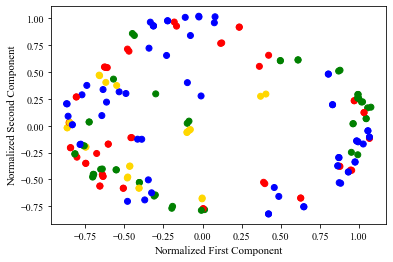

[0.47945061 0.23126902]
[[-4.25529924e-03  7.52534042e-02 -1.71061687e-02  1.31250969e-02
   9.90396546e-01 -8.74070244e-02 -7.29004778e-02  1.91246475e-03
   9.74191723e-06  4.71246585e-04  7.95839113e-04 -2.21558522e-03
   1.97864265e-03  5.43217067e-04  7.14118567e-04]
 [-3.16070513e-01 -3.46860655e-01 -4.96909526e-01 -7.28296351e-01
   2.59736080e-02  1.43080176e-02 -1.84083234e-02  3.44476357e-03
   1.66846299e-03  3.15686974e-03  5.62198083e-03 -1.36627362e-02
  -7.50306100e-03 -1.60400572e-02 -2.60341761e-02]]


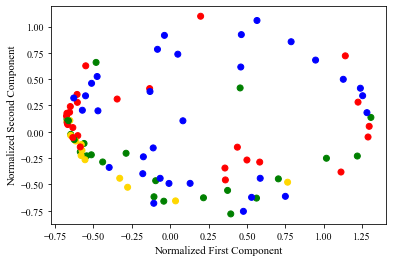

<Figure size 432x288 with 0 Axes>

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca = PCA(n_components=2)
delta_norm_normlize=normalize(delta_norm)
pca.fit(delta_norm_normlize)
print(pca.explained_variance_ratio_)
print(pca.components_)

colors=[]
for label in score2:
    if label == 1 or label == 2 or label == 3 :
        colors.append("r")
    elif label == 4 or label == 5 or label == 6:
        colors.append("g")
    elif label == 7 or label == 8 or label == 9:
        colors.append("gold")
    else:
        colors.append("b")
plt.rcParams["font.family"] = "Times New Roman"
X = pca.fit_transform(delta_norm_normlize)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.xlabel('Normalized First Component',fontsize=11)
plt.ylabel('Normalized Second Component',fontsize=11)

plt.show()



plt.savefig(r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\figNew\pca1.png",dpi=600)

pca = PCA(n_components=2)
delta_norm_normlize=normalize(delta_norm_ncs)
pca.fit(delta_norm_normlize)
print(pca.explained_variance_ratio_)
print(pca.components_)

colors=[]
for label in score:
    if label == 1 or label == 2 or label == 3 :
        colors.append("r")
    elif label == 4 or label == 5 or label == 6:
        colors.append("g")
    elif label == 7 or label == 8 or label == 9:
        colors.append("gold")
    else:
        colors.append("b")

X = pca.fit_transform(delta_norm_normlize)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.rcParams["font.family"] = "Times New Roman"


plt.xlabel('Normalized First Component',fontsize=11)
plt.ylabel('Normalized Second Component',fontsize=11)

plt.show()
plt.savefig(r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\figNew\pca2.png",dpi=600)

0.822
0.865
0.861
0.883
0.855
0.906
0.825
0.866
0.865
0.883
0.879
0.903
[[3.   3.   4.   5.   8.   6.   4.   2.   2.   4.   6.   7.   7.   4.
  7.   5.   5.   6.   4.   2.   7.   3.   3.   0.   0.   0.   0.   0.
  0.   0.  ]
 [4.25 0.34 1.5  3.25 5.25 4.   5.5  2.5  1.06 5.5  4.   5.25 4.   1.88
  8.25 4.5  2.75 4.25 2.88 1.29 4.5  1.34 4.   1.   0.59 1.88 0.15 0.15
  0.15 0.65]]


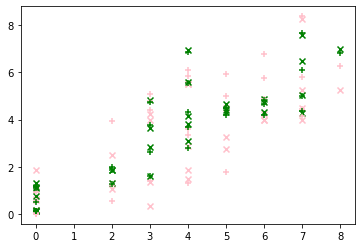

In [13]:
a=7
opt1_1=['kfold','tree',a,a]
opt2_1=['kfold','forest',a,a]
opt3_1=['group','tree',a,a]
opt4_1=['group','forest',a,a]

a=8
opt1_2=['kfold','tree',a,a]
opt2_2=['kfold','forest',a,a]
opt3_2=['group','tree',a,a]
opt4_2=['group','forest',a,a]

acc21_t_k,featureName21_t_k,importance21_t_k,tree21_t_k,accMean21_t_k=valid(delta_norm_ncs,y2,opt1_1)
acc21_f_k,featureName21_f_k,importance21_f_k,tree21_f_k,accMean21_f_k=valid(delta_norm_ncs,y2,opt2_1)
acc21_t_g,featureName21_t_g,importance21_t_g,tree21_t_g,accMean21_t_g=valid(delta_norm_ncs,y2,opt3_1)
acc21_f_g,featureName21_f_g,importance21_f_g,tree21_f_g,accMean21_f_g=valid(delta_norm_ncs,y2,opt4_1)


acc2_t1,label_ncs_t1=test_vote(delta_Ncs_test,score_test,tree21_t_k)
acc2_t1,label_ncs_f1=test_vote(delta_Ncs_test,score_test,tree21_f_k)


acc22_t_k,featureName22_t_k,importance22_t_k,tree22_t_k,accMean22_t_k=valid(delta_norm_ncs,y2,opt1_2)
acc22_f_k,featureName22_f_k,importance22_f_k,tree22_f_k,accMean22_f_k=valid(delta_norm_ncs,y2,opt2_2)
acc22_t_g,featureName22_t_g,importance22_t_g,tree22_t_g,accMean22_t_g=valid(delta_norm_ncs,y2,opt3_2)
acc22_f_g,featureName22_f_g,importance22_f_g,tree22_f_g,accMean22_f_g=valid(delta_norm_ncs,y2,opt4_2)

acc2_t2,label_ncs_t2=test_vote(delta_Ncs_test,score_test,tree22_t_g)
acc2_t2,label_ncs_f2=test_vote(delta_Ncs_test,score_test,tree22_f_g)


print(label_ncs_t1)

plt.scatter(label_ncs_t1[0,:],label_ncs_t1[1,:],marker='x', c='pink')
plt.scatter(label_ncs_f1[0,:],label_ncs_f1[1,:],marker='x', c='green')
plt.scatter(label_ncs_t2[0,:],label_ncs_t2[1,:],marker='+', c='pink')
plt.scatter(label_ncs_f2[0,:],label_ncs_f2[1,:],marker='+', c='green')

data = {"label_ncs_t1": label_ncs_t1, "label_ncs_f1": label_ncs_f1,"label_ncs_t2": label_ncs_t2, "label_ncs_f2": label_ncs_f2}
savemat(r"C:\Users\zz587-admin\Documents\dyspnea\python\scatter4_wearchair.mat", data)


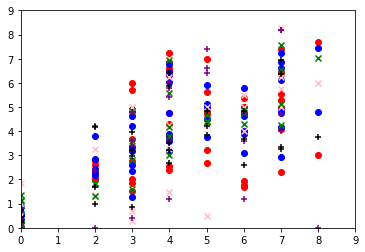

In [14]:

plt.scatter(label_t_all[0,:],label_t_all[1,:],marker='o', c='red',label="NCS+torso-belt+ECG decision tree")

plt.scatter(label_f_all[0,:],label_f_all[1,:],marker='o', c='blue',label="Luck")
plt.scatter(label_ncs_t[0,:],label_ncs_t[1,:],marker='x', c='pink')
plt.scatter(label_ncs_f[0,:],label_ncs_f[1,:],marker='x', c='green')
plt.scatter(label_bio_t[0,:],label_bio_t[1,:],marker='+', c='purple')
plt.scatter(label_bio_f[0,:],label_bio_f[1,:],marker='+', c='black')
plt.xlim(0, 9)
plt.ylim(0, 9)




data = {"label_t_all": label_t_all, "label_f_all": label_t_all,"label_ncs_t": label_ncs_t, "label_ncs_f": label_ncs_f,"label_bio_t": label_bio_t, "label_bio_f": label_bio_f,}
savemat(r"C:\Users\zz587-admin\Documents\dyspnea\python\scatter6.mat", data)

acc1_mean_t_k=0.876
FeatureImportance1:
meanBR=0.402
r2 IN=0.149
CovEX=0.076
rmsrr=0.068
acc2_mean_t_k=0.82
FeatureImportance2:
meanBR=0.357
r2 BR=0.151
r2 EX=0.075
r1 IN=0.071
acc3_mean_t_k=0.82
FeatureImportance3:
meanBR=0.330
r2 IN=0.290
r2 BR=0.078
VarEx=0.074
acc1_mean_f_k=0.884
FeatureImportance1:
meanBR=0.280
r2 IN=0.150
r2 BR=0.103
CovEX=0.054
acc2_mean_f_k=0.87
FeatureImportance2:
meanBR=0.232
r2 BR=0.164
r1 IN=0.103
r2 IN=0.082
acc3_mean_f_k=0.85
FeatureImportance3:
meanBR=0.223
r2 IN=0.184
r2 BR=0.130
VarBR=0.068


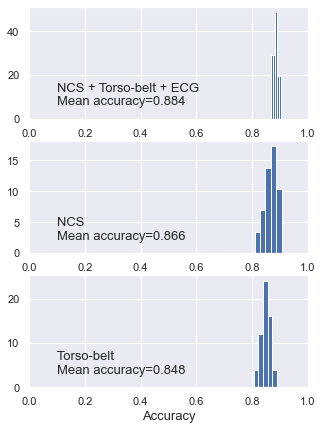

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

#cross-validation plot 
# k-fold result plot 

sns.set(rc={"figure.figsize": (8, 15)}); np.random.seed(0)
size=13

s01='acc1_mean_t_k={n:.3f}\nFeatureImportance1:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean1_t_k,n1=featureName1_t_k[0],s1=importance1_t_k[0],
    n2=featureName1_t_k[1],s2=importance1_t_k[1],n3=featureName1_t_k[2],s3=importance1_t_k[2],n4=featureName1_t_k[3],s4=importance1_t_k[3])
s02='acc2_mean_t_k={n:.2f}\nFeatureImportance2:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean2_t_k,n1=featureName2_t_k[0],s1=importance2_t_k[0],
    n2=featureName2_t_k[1],s2=importance2_t_k[1],n3=featureName2_t_k[2],s3=importance2_t_k[2],n4=featureName2_t_k[3],s4=importance2_t_k[3])
s03='acc3_mean_t_k={n:.2f}\nFeatureImportance3:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean3_t_k,n1=featureName3_t_k[0],s1=importance3_t_k[0],
    n2=featureName3_t_k[1],s2=importance3_t_k[1],n3=featureName3_t_k[2],s3=importance3_t_k[2],n4=featureName3_t_k[3],s4=importance3_t_k[3])
s04='acc1_mean_f_k={n:.3f}\nFeatureImportance1:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean1_f_k,n1=featureName1_f_k[0],s1=importance1_f_k[0],
    n2=featureName1_f_k[1],s2=importance1_f_k[1],n3=featureName1_f_k[2],s3=importance1_f_k[2],n4=featureName1_f_k[3],s4=importance1_f_k[3])
s05='acc2_mean_f_k={n:.2f}\nFeatureImportance2:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean2_f_k,n1=featureName2_f_k[0],s1=importance2_f_k[0],
    n2=featureName2_f_k[1],s2=importance2_f_k[1],n3=featureName2_f_k[2],s3=importance2_f_k[2],n4=featureName2_f_k[3],s4=importance2_f_k[3])
s06='acc3_mean_f_k={n:.2f}\nFeatureImportance3:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean3_f_k,n1=featureName3_f_k[0],s1=importance3_f_k[0],
    n2=featureName3_f_k[1],s2=importance3_f_k[1],n3=featureName3_f_k[2],s3=importance3_f_k[2],n4=featureName3_f_k[3],s4=importance3_f_k[3])
s1='NCS + Torso-belt + ECG \nMean accuracy={n:.3f}\n'.format(n=accMean1_f_k)
s2='NCS \nMean accuracy={n:.3f}\n'.format(n=accMean2_f_k)
s3='Torso-belt \nMean accuracy={n:.3f}\n'.format(n=accMean3_f_k)

plt.figure(figsize=(5,7))
plt.subplot(3,1,1)
plt.hist(acc1_f_k,bins=5,density=True)
plt.xlim((0, 1))
plt.text(0.1,0,s1,fontsize=size)
plt.subplot(3,1,2)
plt.hist(acc2_f_k, bins=5, density=True)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s2,fontsize=size)
plt.subplot(3,1,3)
plt.hist(acc3_f_k, bins=5, density=True)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s3,fontsize=size)
plt.rcParams["font.family"] = "Times New Roman"

plt.savefig(r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\figNew\acc_kfold3.svg",dpi=600)
print(s01)
print(s02)
print(s03)
print(s04)
print(s05)
print(s06)


#mdic = {"a": a, "label": "experiment"}
#savemat(r"C:\Sleep test\dyspnea\data\all\plot\acc_kfold.png", mdic)

acc1_mean_t_g=0.841
FeatureImportance1:
meanBR=0.461
CovEX=0.128
r2 IN=0.111
rmsrr=0.085
acc2_mean_t_g=0.86
FeatureImportance2:
meanBR=0.441
r2 BR=0.196
Varpp=0.057
r2 EX=0.044
acc3_mean_t_g=0.82
FeatureImportance3:
meanBR=0.330
r2 IN=0.262
VarEx=0.102
r1 BR=0.061
acc1_mean_f_g=0.874
FeatureImportance1:
meanBR=0.332
r2 IN=0.161
r2 BR=0.068
CovEX=0.056
acc2_mean_f_g=0.87
FeatureImportance2:
meanBR=0.232
r2 BR=0.164
r1 IN=0.106
r2 IN=0.080
acc3_mean_f_g=0.87
FeatureImportance3:
meanBR=0.229
r2 IN=0.183
r2 BR=0.128
VarEx=0.087


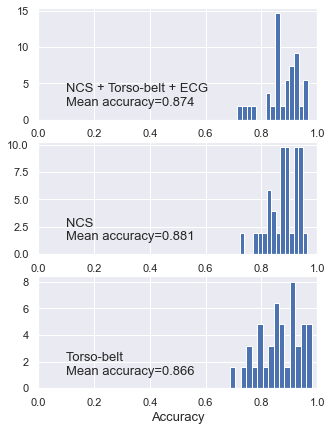

In [62]:
sns.set(rc={"figure.figsize": (8, 15)}); np.random.seed(0)
size=13
# group result plot 

s01='acc1_mean_t_g={n:.3f}\nFeatureImportance1:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean1_t_g,n1=featureName1_t_g[0],s1=importance1_t_g[0],
    n2=featureName1_t_g[1],s2=importance1_t_g[1],n3=featureName1_t_g[2],s3=importance1_t_g[2],n4=featureName1_t_g[3],s4=importance1_t_g[3])
s02='acc2_mean_t_g={n:.2f}\nFeatureImportance2:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean2_t_g,n1=featureName2_t_g[0],s1=importance2_t_g[0],
    n2=featureName2_t_g[1],s2=importance2_t_g[1],n3=featureName2_t_g[2],s3=importance2_t_g[2],n4=featureName2_t_g[3],s4=importance2_t_g[3])
s03='acc3_mean_t_g={n:.2f}\nFeatureImportance3:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean3_t_k,n1=featureName3_t_k[0],s1=importance3_t_k[0],
    n2=featureName3_t_g[1],s2=importance3_t_g[1],n3=featureName3_t_g[2],s3=importance3_t_g[2],n4=featureName3_t_g[3],s4=importance3_t_g[3])
s04='acc1_mean_f_g={n:.3f}\nFeatureImportance1:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean1_f_g,n1=featureName1_f_g[0],s1=importance1_f_g[0],
    n2=featureName1_f_g[1],s2=importance1_f_g[1],n3=featureName1_f_g[2],s3=importance1_f_g[2],n4=featureName1_f_g[3],s4=importance1_f_g[3])
s05='acc2_mean_f_g={n:.2f}\nFeatureImportance2:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean2_f_k,n1=featureName2_f_k[0],s1=importance2_f_k[0],
    n2=featureName2_f_g[1],s2=importance2_f_g[1],n3=featureName2_f_g[2],s3=importance2_f_g[2],n4=featureName2_f_g[3],s4=importance2_f_g[3])
s06='acc3_mean_f_g={n:.2f}\nFeatureImportance3:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean3_f_g,n1=featureName3_f_g[0],s1=importance3_f_g[0],
    n2=featureName3_f_g[1],s2=importance3_f_g[1],n3=featureName3_f_g[2],s3=importance3_f_g[2],n4=featureName3_f_g[3],s4=importance3_f_g[3])
s1='NCS + Torso-belt + ECG \nMean accuracy={n:.3f}\n'.format(n=accMean1_f_g)
s2='NCS \nMean accuracy={n:.3f}\n'.format(n=accMean2_f_g)
s3='Torso-belt \nMean accuracy={n:.3f}\n'.format(n=accMean3_f_g)

plt.figure(figsize=(5,7))
plt.subplot(3,1,1)
plt.hist(acc1_f_g,bins=15,density=True)
plt.xlim((0, 1))
plt.text(0.1,0,s1,fontsize=size)
plt.subplot(3,1,2)
plt.hist(acc2_f_g, bins=15, density=True)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s2,fontsize=size)
plt.subplot(3,1,3)
plt.hist(acc3_f_g, bins=15, density=True)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s3,fontsize=size)
plt.rcParams["font.family"] = "Times New Roman"

plt.savefig(r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\figNew\acc_group3.svg",dpi=600)
print(s01)
print(s02)
print(s03)
print(s04)
print(s05)
print(s06)

0.7666666666666669 0.3962962962962963
0.7074074074074074 0.5814814814814816
[0.6037037037037039, 0.662962962962963, 0.7222222222222224, 0.7592592592592595, 0.7666666666666669, 0.7370370370370367, 0.6851851851851849, 0.6111111111111109, 0.5074074074074073, 0.3962962962962963]


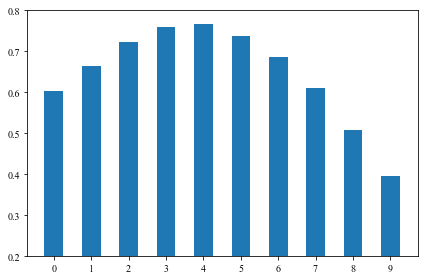

In [4]:
acc_r_temp=[]
acc_c_temp=[]
for i in range(10):
    rand_y = np.random.randint(0,10,size=len(score_test)) 
#score2_test_10=np.repeat(score2_test,10)

    cons_y=np.random.randint(i,i+1,size=len(score_test)) 

    acc_r = 1-abs(score_test-rand_y)/9
    acc_r=np.mean(acc_r)
    acc_r_temp.append(acc_r)

    acc_c = 1-abs(score_test-cons_y)/9
    acc_c=np.mean(acc_c)
    acc_c_temp.append(acc_c)
acc_r_max=max(acc_r_temp) 
acc_r_min=min(acc_r_temp)
acc_c_max=max(acc_c_temp) 
acc_c_min=min(acc_c_temp)
print(acc_c_max,acc_c_min)
print(acc_r_max,acc_r_min)
print(acc_c_temp)



# present case Num +label count 


data=acc_c_temp
x = np.arange(len(data))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, data, width)
# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Accuracy η')
#ax.set_xlabel('fixed-guess Dobj')
ax.set_xticks(x)
ax.set_xticklabels(x)
#ax.legend()
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((0.2, 0.8))


fig.tight_layout()
plt.savefig(r'C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\figNew\fixed guess1.png',dpi=600)